In [19]:
%cd /home/ben/code/knn-research-paper/

/home/ben/code/knn-research-paper


In [20]:
# Import modules
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [21]:
names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "earns-over-50k"  
]

In [22]:
# Read data from CSV
df_preprocessed = pd.read_csv(
    "preprocessed.csv", 
    names=names, 
    delimiter=", *", 
    na_values="?", 
    engine="python"
)

In [23]:
df_preprocessed.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,49440.000000,4.944000e+04,49440.000000,49440.000000,49440.000000,49440.000000
mean,40.479071,1.892657e+05,10.591139,2051.261937,123.122160,42.138182
std,13.191302,1.052846e+05,2.695885,10458.787617,478.822336,12.450239
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,0.909613
25%,30.437194,1.179626e+05,9.000000,0.000000,0.000000,39.141734
50%,39.719759,1.772160e+05,10.000000,0.000000,0.000000,40.000000
75%,49.000000,2.356395e+05,13.000000,0.000000,0.000000,48.000000
max,104.377130,1.484705e+06,20.910963,127985.928966,4356.000000,121.832373


## Split into feature and class data (X, y)
The dataset is then split into features and classes. This is achieved by popping the `earns-over-50k` column from the dataframe. As this can be represented as a boolean value, I will convert it.

In [24]:
# Split data into X_data and y_data
X_data_raw = df_preprocessed.copy()
y_data_raw = X_data_raw.pop("earns-over-50k")

In [25]:
# Convert y_data to boolean
y_data = y_data_raw.replace({">50K": True, "<=50K": False})

## One-hot encode categorical features
Using `pd.get_dummies`, dummy features are created for every category in all categorical features. This allows them to be used within a KNN classifier, which can only work with continuous features. The original columns are then dropped.

In [26]:
# Get categorical features
# categoricals = list(X_data_raw.select_dtypes(exclude=np.number).columns)
categoricals = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country"
]

# Create dummy features for categorical data
X_data_nocat = pd.concat([
        X_data_raw, 
        pd.get_dummies(data=X_data_raw, columns=categoricals)
    ], axis=1)
# Remove original columns
X_data_nocat.drop(categoricals, inplace=True, axis=1)

X_data_nocat.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,age,fnlwgt,education-num,capital-gain,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,49440.000000,4.944000e+04,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,4.944000e+04,49440.000000,49440.000000,...,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000,49440.000000
mean,40.479071,1.892657e+05,10.591139,2051.261937,123.122160,42.138182,40.479071,1.892657e+05,10.591139,2051.261937,...,0.001092,0.002973,0.000405,0.002387,0.001719,0.000485,0.000587,0.919195,0.001578,0.000728
std,13.191302,1.052846e+05,2.695885,10458.787617,478.822336,12.450239,13.191302,1.052846e+05,2.695885,10458.787617,...,0.033031,0.054447,0.020109,0.048796,0.041429,0.022028,0.024212,0.272538,0.039689,0.026975
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,0.909613,17.000000,1.228500e+04,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.437194,1.179626e+05,9.000000,0.000000,0.000000,39.141734,30.437194,1.179626e+05,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,39.719759,1.772160e+05,10.000000,0.000000,0.000000,40.000000,39.719759,1.772160e+05,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,2.356395e+05,13.000000,0.000000,0.000000,48.000000,49.000000,2.356395e+05,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,104.377130,1.484705e+06,20.910963,127985.928966,4356.000000,121.832373,104.377130,1.484705e+06,20.910963,127985.928966,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalise feature data
Feature data is normalised to ensure that features with greater numeric ranges (e.g. capital gain) do not have a greater effect on the result than features with lesser numeric rangers (e.g. age). 

I am using min-max scaling, where the feature is rescaled to a fixed range of 0-1 by subtracting the minimum value of the feature and then dividing by the range.

*Note: Since dummy features are boolean values, they are already on a scale of 0-1 and will therefore not be affected by normalisation.*

In [27]:
scaler = MinMaxScaler()
X_data = pd.DataFrame(
    scaler.fit_transform(X_data_nocat), 
    columns=X_data_nocat.columns
)

# Training
I am using a KNN Classifier for classification, with grid search for hyperparameter optimisation. 
- Possible values for `k` (n_neighbors) are spread over a range of 3-5001
- The weighting strategy can either be `uniform` or `distance`

I tried to create a step to automatically generate possible values for `k`, but I found it was easier to just manually select them.

The number of cross-validation folds is set to 3, although I will test the model with different values in future to make sure there are no vast disparities between them.

In [28]:
# Pipeline for steps in training process
pipeline = Pipeline([
    ("knn", KNeighborsClassifier())
])

# # Used to mathematically generate values of k, making sure they're odd
# make_odd = lambda x: x+1-x%2
# n_neighbors = make_odd(np.logspace(0.3, 3, 8).astype(int)+1)
# print("Neighbour values:", n_neighbors)

# Possible optimal hyperparameters to permute over
param_grid = {
    "knn__n_neighbors": [3, 7, 15, 27, 43, 63, 87, 201, 501, 1001, 2001, 5001],
    "knn__weights": ["uniform", "distance"]
}

# Create Grid Search object with KNN Classifier
gs_knn = GridSearchCV(estimator=pipeline,
                      param_grid=param_grid,
                      cv=3)

In [29]:
# Train the model
gs_knn.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 7, 15, 27, 43, 63, 87, 201,
                                              501, 1001, 2001, 5001],
                         'knn__weights': ['uniform', 'distance']})

In [30]:
# Print best parameters
gs_knn.best_params_

{'knn__n_neighbors': 7, 'knn__weights': 'distance'}

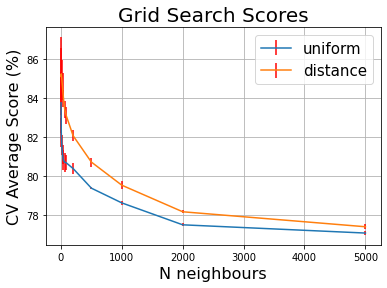

In [31]:
# Plot scores on graph
results = gs_knn.cv_results_

weights = param_grid["knn__weights"]
neighbours = param_grid["knn__n_neighbors"]
new_shape = (
    len(weights), 
    len(neighbours)
)

# Get data to plot and reshape it for pyplot
scores_mean = np.array(results["mean_test_score"]).reshape(new_shape, order="F")
scores_std = np.array(results["std_test_score"]).reshape(new_shape, order="F")

# Plot data
_, ax = plt.subplots(1,1)
for idx, val in enumerate(weights):
    ax.errorbar(
        neighbours, 
        scores_mean[idx,:]*100, 
        yerr=scores_std[idx,:]*100, 
        label=val,
        ecolor="red"
    )
    
# Style graph
# TODO: Use non-linear scale
ax.set_title("Grid Search Scores", fontsize=20)
ax.set_xlabel("N neighbours", fontsize=16)
ax.set_ylabel('CV Average Score (%)', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

## Write best model to file
The best model can then be written to a file using a python pickle, for future testing.

In [32]:
with open("bestmodel", "wb") as file:
    pkl.dump(gs_knn.best_estimator_, file)